# Comparing Two Strategies

Strategy one: Pure random walk
    
Strategy two: Chemotactic random walk

The file includes:
 - Model specification
 - Visualizing the trajectories for 3 cells using each strategy
 - Quantitative comparison of the performance

## Part 1 Model Specification
Please refer to the jupyter notebook of each strategy for detailed walk through of the models.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colors
from matplotlib import patches
import colorspace

SEED = 1024  #Any random seed
np.random.seed(SEED)

#Constants for E.coli tumbling
tumble_time_mu = 0.1

#E.coli movement constants
speed = 20         #um/s, speed of E.coli movement
sec_per_step = 0.5 #Able to respond every 0.5 second
step_size, step_per_sec = speed * sec_per_step, 1.0 / sec_per_step

#Model constants
start = [0, 0]  #All cells start at [0, 0]
ligand_center = [1500, 1500] #Position of highest concentration
center_exponent, start_exponent = 8, 2
origin_to_center = 0 #Distance from start to center, intialized here, will be actually calculated later
saturation_conc = 10 ** 8 #From BNG model

# Calculates Euclidean distance between point a and b
def euclidean_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Exponential gradient, the exponent follows a linear relationship with distance to center
def calc_concentration(pos):
    dist = euclidean_distance(pos, ligand_center)
    exponent = (1 - dist / origin_to_center) * (center_exponent - start_exponent) + start_exponent
    
    return 10 ** exponent

# Horizontal and Vertical movement of tumbling
def tumble_move(curr_dir):
    #Sample the new direction
    new_dir = np.random.uniform(low = 0.0, high = 2 * math.pi)
    new_dir += curr_dir
    
    if new_dir > 2 * math.pi:
        new_dir -= 2 * math.pi #Keep within [0, 2pi]
        
    move_h = math.cos(new_dir) #Horizontal displacement for next run
    move_v = math.sin(new_dir) #Vertical displacement for next run
    
    tumble_time = np.random.exponential(tumble_time_mu) #Length of the tumbling
    
    return new_dir, move_h, move_v, tumble_time

### Simulation method for pure random

In [9]:
def simulate_pure_random(num_cells, duration, time_exp):

    path = np.zeros((num_cells, duration + 1, 2))
    terminals = []

    for rep in range(num_cells):
        # Initialize simulation
        t = 0
        curr_position = np.array(start)
        curr_direction, move_h, move_v, tumble_time = tumble_move(0) #Initialize direction randomly
        past_sec = 0

        while t < duration:

            curr_run_time = np.random.exponential(time_exp) #get wait time before tumble

            curr_position = curr_position + np.array([move_h, move_v]) * speed * curr_run_time
            curr_direction, move_h, move_v, tumble_time = tumble_move(curr_direction)
            t += (curr_run_time + tumble_time)

            #record position approximate for integer number of second
            curr_sec = int(t)
            for sec in range(past_sec, min(curr_sec, duration) + 1):
                path[rep, sec] = curr_position.copy()
                past_sec= curr_sec

        terminals.append((path[rep, -1]))
    
    return terminals, path

### Simulation method for Chemotactic random walk

In [10]:
# Calculate the wait time for next tumbling event
def run_time(curr_conc, past_conc, position, time_exp):
        
    curr_conc = min(curr_conc, saturation_conc) #Can't detect higher concentration if receptors saturates
    past_conc = min(past_conc, saturation_conc)
    change = (curr_conc - past_conc) / past_conc #proportion change in concentration
    exp_run_time = time_exp * (1 + 10 * change)
    
    #print(exp_run_time, curr_conc, past_conc, position)
    
    if exp_run_time < 0.000001:
        exp_run_time = 0.000001 #positive wait times
    elif exp_run_time > 4 * time_exp:
        exp_run_time = 4 * time_exp     #the decrease to tumbling frequency is only to a certain extent
    curr_run_time = np.random.exponential(exp_run_time)
    
    return curr_run_time


def simulate_che(num_cells, duration, time_exp):

    path = np.zeros((num_cells, duration + 1, 2))
    terminals = []

    for rep in range(num_cells):
        # Initialize simulation
        t = 0
        curr_position = np.array(start)
        past_conc = calc_concentration(start) #Initialize concentration
        curr_direction, move_h, move_v, tumble_time = tumble_move(0) #Initialize direction randomly

        while t < duration:
            curr_conc = calc_concentration(curr_position)

            curr_run_time = run_time(curr_conc, past_conc, curr_position, time_exp) #get wait time

            # if run time (r) is within the step (s), run for r second and then tumble
            if curr_run_time < sec_per_step: 
                curr_position = curr_position + np.array([move_h, move_v]) * speed * curr_run_time
                curr_direction, move_h, move_v, tumble_time = tumble_move(curr_direction)
                t += (curr_run_time + tumble_time)

            # if r > s, run for r; then it will be in the next iteration
            else:
                curr_position = curr_position + np.array([move_h, move_v]) * speed * sec_per_step
                t += sec_per_step

            #record position approximate for integer number of second
            curr_sec = int(t)
            if curr_sec <= duration:
                path[rep, curr_sec] = curr_position.copy()
                past_conc = curr_conc

        terminals.append((path[rep, -1]))
    
    return terminals, path


## Part 2: Visualizing trajectories
Run simulation for 3 cells for each strategy, plot path

In [11]:
#Run simulation for 3 cells for each strategy, plot path
duration = 800   #seconds, duration of the simulation
num_cells = 3
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
time_exp = 1.0

terminals_rand, path_rand = simulate_pure_random(num_cells, duration, time_exp)
terminals_che, path_che = simulate_che(num_cells, duration, time_exp)
terminals, path = np.array([terminals_rand, terminals_che]), np.array([path_rand, path_che])

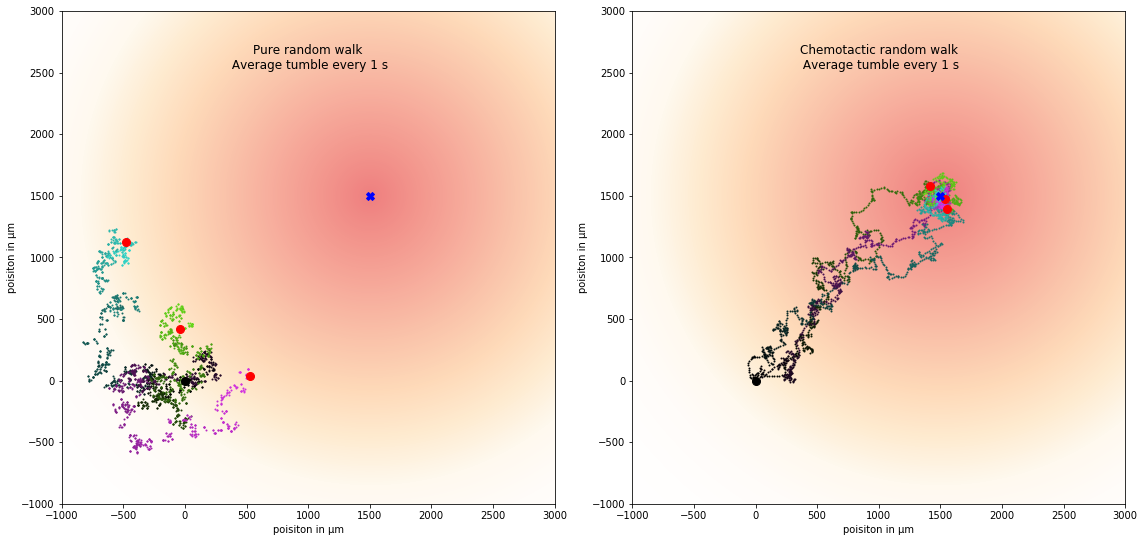

In [12]:
#Below are all for plotting purposes
methods = ["Pure random walk", "Chemotactic random walk"]
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

#First set color map
mycolor = [[256, 256, 256], [256, 255, 254], [256, 253, 250], [256, 250, 240], [255, 236, 209], [255, 218, 185], [251, 196, 171], [248, 173, 157], [244, 151, 142], [240, 128, 128]] #from coolors：）
for i in mycolor:
    for j in range(len(i)):
        i[j] *= (1/256)
cmap_color = colors.LinearSegmentedColormap.from_list('my_list', mycolor)

conc_matrix = np.zeros((4000, 4000))
for i in range(4000):
    for j in range(4000):
        conc_matrix[i][j] = math.log(calc_concentration([i - 1000, j - 1000]))

for m in range(2):
    ax[m].imshow(conc_matrix.T, cmap=cmap_color, interpolation='nearest', extent = [-1000, 3000, -1000, 3000], origin = 'lower')

    #Plot simulation results
    time_frac = 1.0 / duration
    #Time progress: dark -> colorful
    for t in range(duration):
        ax[m].plot(path[m,0,t,0], path[m,0,t,1], 'o', markersize = 1, color = (0.2 * time_frac * t, 0.85 * time_frac * t, 0.8 * time_frac * t))
        ax[m].plot(path[m,1,t,0], path[m,1,t,1], 'o', markersize = 1, color = (0.85 * time_frac * t, 0.2 * time_frac * t, 0.9 * time_frac * t))
        ax[m].plot(path[m,2,t,0], path[m,2,t,1], 'o', markersize = 1, color = (0.4 * time_frac * t, 0.85 * time_frac * t, 0.1 * time_frac * t))
    ax[m].plot(start[0], start[1], 'ko', markersize = 8)
    for i in range(num_cells):
        ax[m].plot(terminals[m][i][0], terminals[m][i][1], 'ro', markersize = 8)
    ax[m].plot(1500, 1500, 'bX', markersize = 8)
    #ax.plot(path[:,0], path[:,1], '-', color = 'grey')

    #Indicate the saturation areas
    ax[m].set_title("{}\n Average tumble every 1 s".format(methods[m]), x = 0.5, y = 0.87)
    ax[m].set_xlim(-1000, 3000)
    ax[m].set_ylim(-1000, 3000)
    ax[m].set_xlabel("poisiton in μm")
    ax[m].set_ylabel("poisiton in μm")

fig.tight_layout()

plt.show()

## Part 3: Quantitative comparison
Run simulation for 500 cells for each strategy, plot average distance to the goal

In [13]:
#Run simulation for 3 cells with different background tumbling frequencies, Plot path

duration = 1500   #seconds, duration of the simulation
num_cells = 500
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
time_exp = 1.0

terminals_rand, path_rand = simulate_pure_random(num_cells, duration, time_exp)
terminals_che, path_che = simulate_che(num_cells, duration, time_exp)
terminals, path = np.array([terminals_rand, terminals_che]), np.array([path_rand, path_che])

all_distance = np.zeros((2, num_cells, duration)) #Initialize to store results

for m in range(2):
    for c in range(num_cells):
        for t in range(duration):
            pos = path[m, c, t]
            dist = euclidean_distance(ligand_center, pos)
            all_distance[m, c, t] = dist

all_dist_avg = np.mean(all_distance, axis = 1)
all_dist_std = np.std(all_distance, axis = 1)

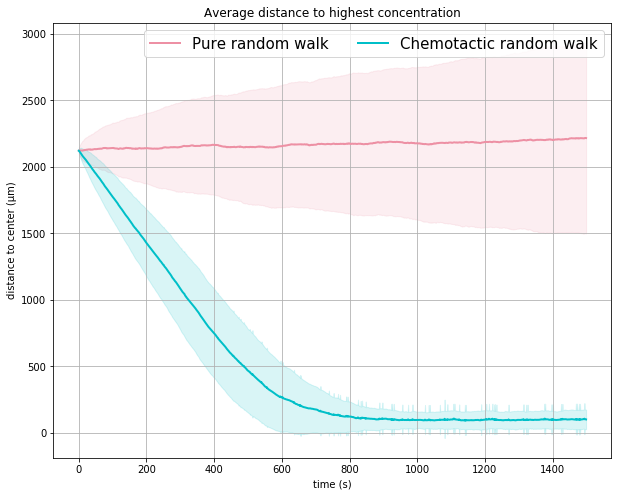

In [14]:
#Below are all for plotting purposes
#Define the colors to use
colors1 = colorspace.qualitative_hcl(h=[0, 200.], c = 60, l = 70, pallete = "dynamic")(2)

xs = np.arange(0, duration)

fig, ax = plt.subplots(1, figsize = (10, 8))

for m in range(2):
    mu, sig = all_dist_avg[m], all_dist_std[m]
    ax.plot(xs, mu, lw=2, label="{}".format(methods[m]), color=colors1[m])
    ax.fill_between(xs, mu + sig, mu - sig, color = colors1[m], alpha=0.15)

ax.set_title("Average distance to highest concentration")
ax.set_xlabel('time (s)')
ax.set_ylabel('distance to center (µm)')
#ax.hlines(0, 0, duration, colors='gray', linestyles='dashed', label='concentration 10^8')
ax.legend(loc='upper right', ncol = 2, fontsize = 15)

ax.grid()